# Machine Learning
## Answer 5

In [1]:
import folium
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

### Preprocessing and visualization

In [2]:
#!pip install catboost

In [3]:
df = pd.read_csv("C:\\Users\\Lenovo\\OneDrive\\Desktop\\Pre Placement Assesment\\Placement-assignment_Pranit-Anap\\Machine Learning\\rideshare_kaggle.csv\\rideshare_kaggle.csv")

In [4]:
df["price"] = df["price"].fillna(value=np.mean(df["price"]))

In [5]:
df["START_DATE"] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M')

In [6]:
df['HOURS'] = [x.hour for x in df['START_DATE']]
df['DAY'] = [x.day for x in df['START_DATE']]
df['MONTH'] = [x.month for x in df['START_DATE']]
df['DAY_OF_WEEK'] = [x.day_of_week for x in df['START_DATE']]
df["WEEKDAY"] = [calendar.day_name[x.day_of_week] for x in df['START_DATE']]

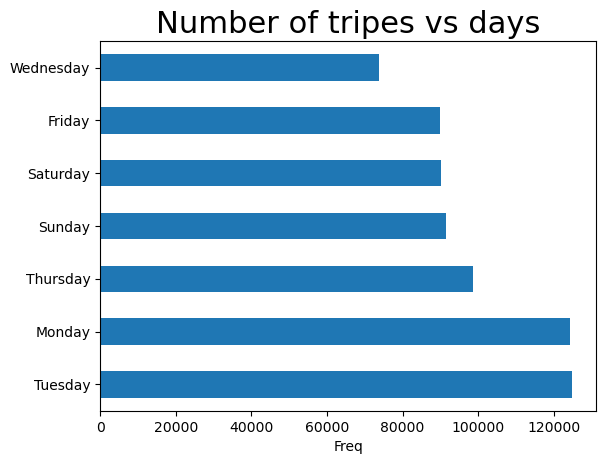

In [7]:
df["WEEKDAY"].value_counts().plot(kind='barh')
plt.xlabel("Freq")
plt.title("Number of tripes vs days", fontsize=22)
plt.show()

In [8]:
df['hourRange'] = df.hour.apply( 
                    lambda x: ('00 - 03 am' if 0<=x<=3 else 
                    ('04 - 07 am' if  4<=x<=7 else 
                    ('08 - 11 am' if  8<=x<=11 else 
                    ('12 - 15 am' if 12<=x<=15 else 
                    ('16 - 19 am' if 16<=x<=19 else 
                    ('20 - 23 am' if 20<=x<=723 else 
                    'missed')))))))
df["hourRange"].sample(10)

172087    20 - 23 am
575688    16 - 19 am
109664    12 - 15 am
138510    00 - 03 am
44618     12 - 15 am
98084     08 - 11 am
455157    12 - 15 am
207411    12 - 15 am
50892     04 - 07 am
43254     08 - 11 am
Name: hourRange, dtype: object

In [9]:
# Threshold for removing correlated variables
threshold = 0.9
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold) ]
print('There are %d columns to remove.' % (len(to_drop)))
to_drop

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8908\3886206770.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


There are 23 columns to remove.


['apparentTemperature',
 'windGust',
 'windGustTime',
 'temperatureHighTime',
 'temperatureLowTime',
 'apparentTemperatureHigh',
 'apparentTemperatureHighTime',
 'apparentTemperatureLow',
 'apparentTemperatureLowTime',
 'visibility.1',
 'sunriseTime',
 'sunsetTime',
 'uvIndexTime',
 'temperatureMinTime',
 'temperatureMax',
 'temperatureMaxTime',
 'apparentTemperatureMin',
 'apparentTemperatureMinTime',
 'apparentTemperatureMax',
 'apparentTemperatureMaxTime',
 'HOURS',
 'DAY',
 'MONTH']

In [10]:
df = df.drop(columns = to_drop)
print('data shape after removing collinear vaiables: ', df.shape)

data shape after removing collinear vaiables:  (693071, 41)


In [11]:
def outliers(col):
    global col_out
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3-Q1
    upper_limit = Q3 + (IQR*1.5)
    lower_limit = Q1 - (IQR*1.5)
    df1 = df[ (df[col] > upper_limit) | (df[col] < lower_limit)] 
    df.loc[ (df[col] > upper_limit) | (df[col] < lower_limit),col]=np.nan
    if df1.shape[0] != 0:
        print(col, ":", df1.shape)
        print('-----------------')
        col_out.append(col)
    return col_out, df1.shape[0]

In [12]:
numerical = df.select_dtypes(['int64', 'float64']).columns
print("number of outliers for each column")
print('-----------------')
l = []
col_out = []
for col in numerical:
    col_out, val = outliers(col)
    l.append(val)

number of outliers for each column
-----------------
price : (7982, 41)
-----------------
distance : (8662, 41)
-----------------
surge_multiplier : (20975, 41)
-----------------
latitude : (88546, 41)
-----------------
temperature : (36659, 41)
-----------------
precipIntensity : (150828, 41)
-----------------
precipProbability : (150828, 41)
-----------------
visibility : (136839, 41)
-----------------
temperatureHigh : (163878, 41)
-----------------
dewPoint : (37283, 41)
-----------------
uvIndex : (159407, 41)
-----------------
temperatureMin : (4447, 41)
-----------------


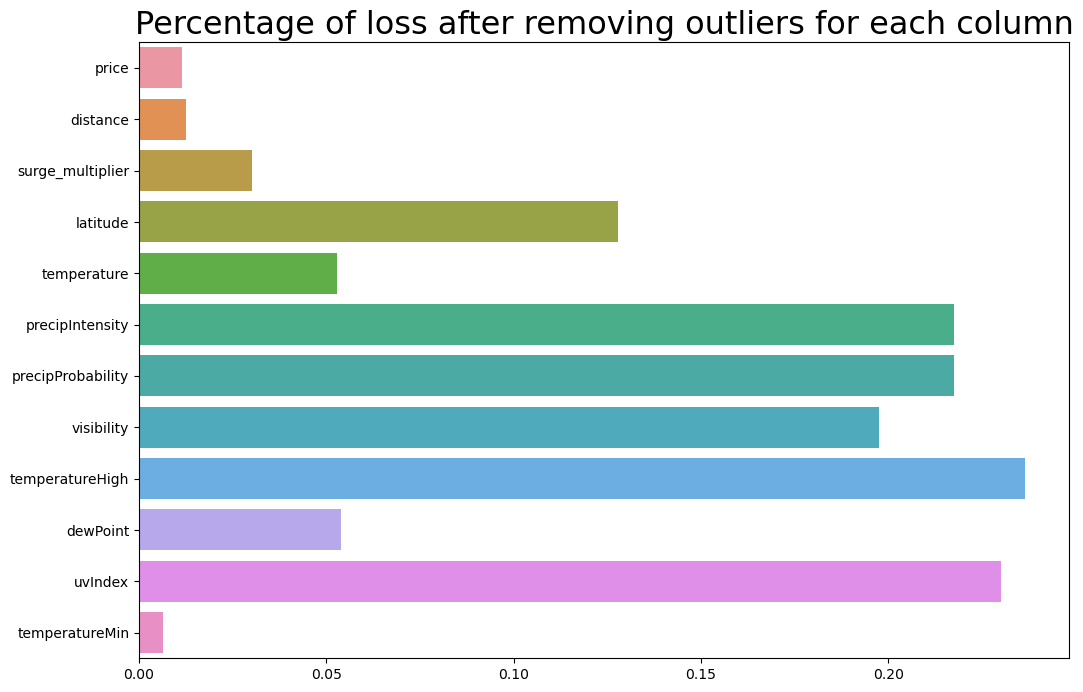

In [13]:
l = list(filter(lambda num: num != 0, l))
l = [i/df.shape[0] for i in l]
plt.figure(figsize = (12,8))
sns.barplot(x=l, y=col_out)
plt.title("Percentage of loss after removing outliers for each column", fontsize=23)
plt.show()

In [14]:
df["price_per_mile"] = df["price"] / df["distance"]

In [15]:
print('Before deleting outliers: ',df.shape)
df.dropna(inplace=True)
print('After deleting outliers: ',df.shape)

Before deleting outliers:  (693071, 42)
After deleting outliers:  (234930, 42)


In [16]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
for i in df.columns:
    if df[i].dtype == "O":
        df[i] = le.fit_transform(df[i])

### KMEANS Clustering  

In [17]:
# Select relevant columns for clustering
columns_for_clustering = ['latitude', 'longitude', 'price', 'distance', 'temperature', 'humidity']

# Extract the data for clustering

cluster_data = df[columns_for_clustering]

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(cluster_data)

# Add cluster labels to the DataFrame
df['cluster_label'] = kmeans.labels_


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
# Calculate inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)


Inertia: 4122790.652568973


In [19]:
import random
# Define the number of samples to display on the map
num_samples = 1000  # Adjust this number as per your preference and system capabilities

# Randomly select a subset of samples
random_indices = random.sample(range(len(df)), min(num_samples, len(df)))
sampled_df = df.iloc[random_indices]

# Create a map centered on a specific location
map_center = [42.3647, -71.0542]  # Latitude and longitude of the map center
map_zoom = 12  # Zoom level of the map

# Create the map object
m = folium.Map(location=map_center, zoom_start=map_zoom)

# Add markers for each sampled Uber trip
for _, row in sampled_df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    # Add a marker for each Uber trip
    folium.Marker([lat, lon]).add_to(m)

# Display the map
m

### PRECIDTING PRICES USING CATBOOSTREGRESSOR

In [20]:
df.dropna(inplace = True)
X=df.drop(['price',"START_DATE","price_per_mile"],axis=1)
y=df['price_per_mile']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=40)


In [21]:
categorical_features_indices = np.where(X.dtypes != float)[0]

# Use the Pool constructor
train_data = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_data = Pool(X_test, y_test, cat_features=categorical_features_indices)

In [22]:
model = CatBoostRegressor(depth= 6, l2_leaf_reg= 3, iterations= 1000, learning_rate=0.1)

In [23]:
model.fit(train_data)

0:	learn: 12.8968089	total: 1.1s	remaining: 18m 19s
1:	learn: 12.1803342	total: 2.09s	remaining: 17m 22s
2:	learn: 11.5914075	total: 2.83s	remaining: 15m 40s
3:	learn: 11.0032521	total: 3.42s	remaining: 14m 10s
4:	learn: 10.5366008	total: 4.22s	remaining: 14m
5:	learn: 9.9182967	total: 5.01s	remaining: 13m 49s
6:	learn: 9.4205984	total: 5.76s	remaining: 13m 37s
7:	learn: 9.0195153	total: 6.56s	remaining: 13m 34s
8:	learn: 8.6530522	total: 7.15s	remaining: 13m 7s
9:	learn: 8.2559253	total: 8.02s	remaining: 13m 14s
10:	learn: 8.0007819	total: 8.76s	remaining: 13m 7s
11:	learn: 7.7989586	total: 9.44s	remaining: 12m 57s
12:	learn: 7.5439901	total: 10s	remaining: 12m 39s
13:	learn: 7.3902113	total: 10.6s	remaining: 12m 25s
14:	learn: 7.0513301	total: 11.1s	remaining: 12m 10s
15:	learn: 6.8672655	total: 11.9s	remaining: 12m 12s
16:	learn: 6.5165945	total: 12.8s	remaining: 12m 18s
17:	learn: 6.3645648	total: 13.5s	remaining: 12m 14s
18:	learn: 6.2186440	total: 14.1s	remaining: 12m 5s
19:	lear

157:	learn: 1.7353060	total: 1m 30s	remaining: 8m
158:	learn: 1.7339451	total: 1m 30s	remaining: 7m 58s
159:	learn: 1.7339020	total: 1m 31s	remaining: 7m 58s
160:	learn: 1.7338597	total: 1m 31s	remaining: 7m 57s
161:	learn: 1.7011884	total: 1m 31s	remaining: 7m 55s
162:	learn: 1.6947799	total: 1m 32s	remaining: 7m 54s
163:	learn: 1.6849298	total: 1m 33s	remaining: 7m 54s
164:	learn: 1.6849276	total: 1m 33s	remaining: 7m 52s
165:	learn: 1.6692430	total: 1m 33s	remaining: 7m 51s
166:	learn: 1.6621349	total: 1m 34s	remaining: 7m 51s
167:	learn: 1.6583353	total: 1m 34s	remaining: 7m 50s
168:	learn: 1.6533788	total: 1m 35s	remaining: 7m 50s
169:	learn: 1.6414248	total: 1m 36s	remaining: 7m 49s
170:	learn: 1.6373519	total: 1m 36s	remaining: 7m 48s
171:	learn: 1.6298398	total: 1m 37s	remaining: 7m 47s
172:	learn: 1.6243130	total: 1m 37s	remaining: 7m 46s
173:	learn: 1.6222869	total: 1m 38s	remaining: 7m 45s
174:	learn: 1.6222811	total: 1m 38s	remaining: 7m 44s
175:	learn: 1.6210222	total: 1m 

310:	learn: 1.2347671	total: 2m 52s	remaining: 6m 22s
311:	learn: 1.2335192	total: 2m 53s	remaining: 6m 21s
312:	learn: 1.2329132	total: 2m 53s	remaining: 6m 20s
313:	learn: 1.2314808	total: 2m 53s	remaining: 6m 19s
314:	learn: 1.2314688	total: 2m 54s	remaining: 6m 19s
315:	learn: 1.2286232	total: 2m 54s	remaining: 6m 18s
316:	learn: 1.2244059	total: 2m 55s	remaining: 6m 17s
317:	learn: 1.2222781	total: 2m 55s	remaining: 6m 17s
318:	learn: 1.2222532	total: 2m 56s	remaining: 6m 16s
319:	learn: 1.2189736	total: 2m 56s	remaining: 6m 15s
320:	learn: 1.2181979	total: 2m 57s	remaining: 6m 15s
321:	learn: 1.2176487	total: 2m 57s	remaining: 6m 14s
322:	learn: 1.2172195	total: 2m 58s	remaining: 6m 13s
323:	learn: 1.2131523	total: 2m 58s	remaining: 6m 13s
324:	learn: 1.2094290	total: 2m 59s	remaining: 6m 11s
325:	learn: 1.2088585	total: 2m 59s	remaining: 6m 11s
326:	learn: 1.2082280	total: 3m	remaining: 6m 10s
327:	learn: 1.2048112	total: 3m	remaining: 6m 9s
328:	learn: 1.2041083	total: 3m 1s	re

464:	learn: 1.0559182	total: 4m 12s	remaining: 4m 50s
465:	learn: 1.0554846	total: 4m 13s	remaining: 4m 50s
466:	learn: 1.0540644	total: 4m 13s	remaining: 4m 49s
467:	learn: 1.0534847	total: 4m 14s	remaining: 4m 48s
468:	learn: 1.0528600	total: 4m 14s	remaining: 4m 48s
469:	learn: 1.0520209	total: 4m 15s	remaining: 4m 47s
470:	learn: 1.0518707	total: 4m 15s	remaining: 4m 46s
471:	learn: 1.0515552	total: 4m 16s	remaining: 4m 46s
472:	learn: 1.0512265	total: 4m 16s	remaining: 4m 45s
473:	learn: 1.0504111	total: 4m 17s	remaining: 4m 45s
474:	learn: 1.0502096	total: 4m 17s	remaining: 4m 44s
475:	learn: 1.0493375	total: 4m 17s	remaining: 4m 43s
476:	learn: 1.0486218	total: 4m 18s	remaining: 4m 43s
477:	learn: 1.0484041	total: 4m 18s	remaining: 4m 42s
478:	learn: 1.0473799	total: 4m 19s	remaining: 4m 42s
479:	learn: 1.0471665	total: 4m 19s	remaining: 4m 41s
480:	learn: 1.0468944	total: 4m 20s	remaining: 4m 40s
481:	learn: 1.0466423	total: 4m 20s	remaining: 4m 40s
482:	learn: 1.0450219	total:

617:	learn: 0.9553626	total: 5m 32s	remaining: 3m 25s
618:	learn: 0.9550768	total: 5m 32s	remaining: 3m 24s
619:	learn: 0.9530274	total: 5m 33s	remaining: 3m 24s
620:	learn: 0.9519367	total: 5m 33s	remaining: 3m 23s
621:	learn: 0.9515204	total: 5m 34s	remaining: 3m 23s
622:	learn: 0.9500271	total: 5m 34s	remaining: 3m 22s
623:	learn: 0.9497163	total: 5m 35s	remaining: 3m 22s
624:	learn: 0.9494461	total: 5m 35s	remaining: 3m 21s
625:	learn: 0.9491230	total: 5m 36s	remaining: 3m 20s
626:	learn: 0.9480896	total: 5m 37s	remaining: 3m 20s
627:	learn: 0.9471766	total: 5m 37s	remaining: 3m 19s
628:	learn: 0.9468696	total: 5m 37s	remaining: 3m 19s
629:	learn: 0.9468060	total: 5m 38s	remaining: 3m 18s
630:	learn: 0.9462584	total: 5m 38s	remaining: 3m 18s
631:	learn: 0.9461076	total: 5m 39s	remaining: 3m 17s
632:	learn: 0.9459404	total: 5m 39s	remaining: 3m 17s
633:	learn: 0.9440934	total: 5m 40s	remaining: 3m 16s
634:	learn: 0.9440008	total: 5m 40s	remaining: 3m 15s
635:	learn: 0.9439934	total:

770:	learn: 0.8728429	total: 6m 47s	remaining: 2m 1s
771:	learn: 0.8726462	total: 6m 48s	remaining: 2m
772:	learn: 0.8725320	total: 6m 48s	remaining: 1m 59s
773:	learn: 0.8721350	total: 6m 48s	remaining: 1m 59s
774:	learn: 0.8715798	total: 6m 49s	remaining: 1m 58s
775:	learn: 0.8709373	total: 6m 49s	remaining: 1m 58s
776:	learn: 0.8709259	total: 6m 50s	remaining: 1m 57s
777:	learn: 0.8699526	total: 6m 50s	remaining: 1m 57s
778:	learn: 0.8698573	total: 6m 51s	remaining: 1m 56s
779:	learn: 0.8698108	total: 6m 51s	remaining: 1m 56s
780:	learn: 0.8697575	total: 6m 52s	remaining: 1m 55s
781:	learn: 0.8695745	total: 6m 52s	remaining: 1m 55s
782:	learn: 0.8694195	total: 6m 53s	remaining: 1m 54s
783:	learn: 0.8692917	total: 6m 53s	remaining: 1m 53s
784:	learn: 0.8690869	total: 6m 54s	remaining: 1m 53s
785:	learn: 0.8689648	total: 6m 54s	remaining: 1m 52s
786:	learn: 0.8688079	total: 6m 55s	remaining: 1m 52s
787:	learn: 0.8687358	total: 6m 55s	remaining: 1m 51s
788:	learn: 0.8677938	total: 6m 5

924:	learn: 0.8246642	total: 8m 6s	remaining: 39.4s
925:	learn: 0.8245112	total: 8m 6s	remaining: 38.9s
926:	learn: 0.8243224	total: 8m 7s	remaining: 38.4s
927:	learn: 0.8242989	total: 8m 8s	remaining: 37.9s
928:	learn: 0.8242390	total: 8m 8s	remaining: 37.3s
929:	learn: 0.8241824	total: 8m 8s	remaining: 36.8s
930:	learn: 0.8240456	total: 8m 9s	remaining: 36.3s
931:	learn: 0.8232461	total: 8m 9s	remaining: 35.7s
932:	learn: 0.8231787	total: 8m 10s	remaining: 35.2s
933:	learn: 0.8229626	total: 8m 10s	remaining: 34.7s
934:	learn: 0.8229378	total: 8m 11s	remaining: 34.1s
935:	learn: 0.8227356	total: 8m 11s	remaining: 33.6s
936:	learn: 0.8226587	total: 8m 12s	remaining: 33.1s
937:	learn: 0.8225078	total: 8m 12s	remaining: 32.6s
938:	learn: 0.8225063	total: 8m 13s	remaining: 32s
939:	learn: 0.8224795	total: 8m 13s	remaining: 31.5s
940:	learn: 0.8223144	total: 8m 14s	remaining: 31s
941:	learn: 0.8222811	total: 8m 14s	remaining: 30.5s
942:	learn: 0.8221650	total: 8m 15s	remaining: 29.9s
943:	

In [24]:
pred = model.predict(X_test)
pred

array([21.51566567,  5.72360516, 13.0068448 , ..., 14.84921766,
        4.20466166,  3.55363207])

In [25]:
y_true =np.array(y_test)

#### EVALUATING MODEL 

In [26]:
r2 = model.score(test_data) 
rmse = (np.sqrt(mean_squared_error(y_true, pred)))
print("R2:", r2)
print("RMSE:", rmse)

R2: 0.956821754035951
RMSE: 2.9605631176488325
